## Notes

* the avaliable training dataset from the S2 is Mesa. 

* Cut the images into 4\*32\*32 tiles

* Output the images into training dataset folder

In [1]:
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt
import os
from osgeo import gdal
import math
#from PIL import Image
from tqdm import tqdm
import time

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
flist = glob.glob("/home/data/Sentinel_Mesa_4Bands_Training/"+"*.tif")
flist.sort()

In [7]:
image_list = []
for f in flist:
    val = gdal.Open(f).ReadAsArray()
    image_list.append(val)
image_arr = np.asarray(image_list)
#print(image_arr.shape)
# create a dataframe to store the band parameters
para=pd.DataFrame()
for i in range(image_arr.shape[1]):

    data_scaled=image_arr[:,i,::]*1 # no scaled
    
    max = np.max(data_scaled)
    min = np.min(data_scaled)
    mean = np.mean(data_scaled)
    median = np.median(data_scaled)
    std = np.std(data_scaled)


    values = [ max, min, mean, median, std]
    names = [ 'max', 'min', 'mean', 'median', 'std']
    
    out = pd.Series(dict(zip(names, values)))   
    row = pd.Series({'band':str(i+1)})
    row = row.append(out)
    print('band '+str(i+1)+" finished")

    para = para.append(row,ignore_index=True)

del image_arr,image_list

band 1 finished
band 2 finished
band 3 finished
band 4 finished


In [8]:
para

,band,max,min,mean,median,std
0,1,18408.0,0.0,1062.885748,942.0,636.828560
1,2,18855.0,0.0,990.512764,876.0,636.148088
2,3,23857.0,0.0,1005.646746,846.0,758.510431
3,4,22105.0,0.0,2007.063252,1923.0,813.450629


In [8]:
band_dict = {1: "Band 1 - Blue", 2: "Band 2 - Green", 3: "Band 3 - Red", 4: "Band 4 - NIR"}

In [9]:
def normalizaed_data(img):
    #min-max normalization of the image based on all images
    #four bands, for different min, max
    max = [18408, 18855, 23857, 22105]
    min = [0, 0, 0, 0]
    img_normalized=np.zeros(img.shape)
    for i in range(4):
        img_normalized[i,:,:]=(img[i,:,:]-min[i])/(max[i]-min[i])
    
    return img_normalized.astype(np.float64)


In [10]:
def recover_data(arr):
    #recover min-max normalized image
    max = [18408, 18855, 23857, 22105]
    min = [0, 0, 0, 0]
    img_recovered=np.zeros(arr.shape)
    for i in range(4):
        img_recovered[i,:,:]=arr[i,:,:]*(max[i]-min[i])+min[i]
    
    return img_recovered.astype(np.float64)

In [15]:
def load_image(img_src,normalization = True):
    '''
    args:
    img_src - directory to the target image

    return:
    data_mtrx - a dictionary of two data matrices for pre and post fire; each of them is in 3 dimensions (band,rows,cols)
    meta_data - metadata includes: transformation, projection, numerber of rows, number of columns, number of bands
    band_dict - band dictionary includes the information of each band
    '''
    
    s2_name = os.path.basename(img_src)[:-4]
    loc_name = 'Mesa'
    print("Loading image: %s - %s" %(loc_name,s2_name))
    
    ds = gdal.Open(img_src)
    ds_arr = ds.ReadAsArray().astype(np.float32)
    
    if normalization:
        ds_arr = normalizaed_data(ds_arr)
    
    print("Loading image is done!")
    return ds_arr,s2_name,loc_name

In [16]:
def create_image_tile(img_src, out_dir, stride_size=32, tile_size = 32):
    '''
    args:
    data_mtrx - a path to 3-dimensional data matrix read from a satellite image

    tile_size - the size of the tile in integer, the default size is 3*3
    stride_size - the size of the stride in integer, for the size of moving pixels for each tile
    output - True/False, whether output the data matrix, the default is False
    out_dir - output directory of the tiled image the default is None. If the ouput is True, the out_dir is required. Output data type should be acceptable for the numpy.save, npy is recommended.

    return:
    data_mtrx_tile - a data matrix of the image after tiling

    '''
    data_mtrx, ps_name, loc_name = load_image(img_src)

    bands, rows, cols = data_mtrx.shape
    
    print("Start tiling the image...")
 
    new_rows = math.floor(1+(rows-tile_size)/stride_size) #asking huiqi to check this one, need to be changed
    new_cols = math.floor(1+(cols-tile_size)/stride_size)
    
    print("The numbers of rows and columns after tiling are (%d, %d)"%(new_rows,new_cols))

    for i in range(new_rows):
        if i<10:
            str_new_rows = '000'+str(i)
        elif i<100:
            str_new_rows = '00'+str(i)
        elif i<1000:
            str_new_rows = '0'+str(i)
        else:
            str_new_rows = str(i)
        for j in range(new_cols):
            if j<10:
                str_new_cols = '000'+str(j)
            elif j<100:
                str_new_cols = '00'+str(j)
            elif j<1000:
                str_new_cols = '0'+str(j)
            else:
                str_new_cols = str(j)
            cropped_arr = data_mtrx[:,i*stride_size : (i*stride_size+tile_size), j*stride_size : (j*stride_size+tile_size)]
            cropped_arr[cropped_arr==0.0]=np.nan
            if np.isnan(cropped_arr).sum() == 0:
                output_file = os.path.join(out_dir,loc_name+"_"+ps_name+"_"+str_new_rows+"_"+str_new_cols+".npy")
                np.save(output_file, cropped_arr)
            if i == 0 and j==0:
                print("After tiling, the size of data matrix becomes: ", cropped_arr.shape)
    del data_mtrx, cropped_arr

In [17]:
for tr_f in flist:
    start = time.time()
    create_image_tile(tr_f,out_dir = "/home/data/S2_Training")
    print("Done. %.2f mintues" %((time.time()-start)/60))

Loading image: Mesa - S2A_20180701
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (343, 343)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 0.79 mintues
Loading image: Mesa - S2A_20180711
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (343, 343)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 0.82 mintues
Loading image: Mesa - S2A_20180810
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (343, 343)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 1.00 mintues
Loading image: Mesa - S2A_20180830
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (343, 343)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 0.98 mintues
Loading image: Mesa - S2A_20180909
Loading image is done!
Start tiling the image...
The numbers of rows and 

In [19]:
test = np.load("/home/data/S2_Training/Mesa_S2A_20180909_0034_0223.npy")
test = test*10

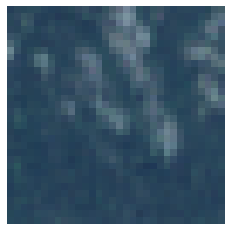

In [20]:
plt.figure()
plt.imshow(np.moveaxis(test[[2,1,0],:,:],0,-1))
plt.axis("off")
plt.show()

In [25]:
test_list = glob.glob("/home/data/S2_Training/"+"*.npy")

In [26]:
len(test_list)

941190